# Instanciating the model


In [ ]:
from time import time
import argparse
import os

from torch import device
import torch
from torch import optim
import numpy as np

from data_prep import NLIGenData2, OntoGenData, HuggingYelp2
from disentanglement_qkv.models import DisentanglementTransformerVAE, LaggingDisentanglementTransformerVAE
from disentanglement_qkv.h_params import DefaultTransformerHParams as HParams
from disentanglement_qkv.graphs import *
from components.criteria import *
parser = argparse.ArgumentParser()
from torch.nn import MultiheadAttention
# Training and Optimization
k, kz, klstm = 1, 8, 2
parser.add_argument("--test_name", default='unnamed', type=str)
parser.add_argument("--data", default='nli', choices=["nli", "ontonotes", "yelp"], type=str)
parser.add_argument("--csv_out", default='disentFinal.csv', type=str)
parser.add_argument("--max_len", default=17, type=int)
parser.add_argument("--batch_size", default=128, type=int)
parser.add_argument("--grad_accu", default=1, type=int)
parser.add_argument("--n_epochs", default=20, type=int)
parser.add_argument("--test_freq", default=32, type=int)
parser.add_argument("--complete_test_freq", default=160, type=int)
parser.add_argument("--generation_weight", default=1, type=float)
parser.add_argument("--device", default='cuda:0', choices=["cuda:0", "cuda:1", "cuda:2", "cpu"], type=str)
parser.add_argument("--embedding_dim", default=128, type=int)#################"
parser.add_argument("--pretrained_embeddings", default=False, type=bool)#################"
parser.add_argument("--z_size", default=96*kz, type=int)#################"
parser.add_argument("--z_emb_dim", default=192*k, type=int)#################"
parser.add_argument("--n_latents", default=[16, 16, 16], nargs='+', type=int)#################"
parser.add_argument("--text_rep_l", default=3, type=int)
parser.add_argument("--text_rep_h", default=192*k, type=int)
parser.add_argument("--encoder_h", default=192*k, type=int)#################"
parser.add_argument("--encoder_l", default=2, type=int)#################"
parser.add_argument("--decoder_h", default=192*k, type=int)
parser.add_argument("--decoder_l", default=2, type=int)#################"
parser.add_argument("--highway", default=False, type=bool)
parser.add_argument("--markovian", default=True, type=bool)
parser.add_argument('--minimal_enc', dest='minimal_enc', action='store_true')
parser.add_argument('--no-minimal_enc', dest='minimal_enc', action='store_false')
parser.set_defaults(minimal_enc=False)
parser.add_argument("--losses", default='VAE', choices=["VAE", "IWAE" "LagVAE"], type=str)
parser.add_argument("--graph", default='Normal', choices=["Vanilla", "Discrete", "IndepInfer", "Normal", "NormalConGen",
                                                          "NormalSimplePrior", "Normal2",  "NormalLSTM"], type=str)
parser.add_argument("--training_iw_samples", default=1, type=int)
parser.add_argument("--testing_iw_samples", default=5, type=int)
parser.add_argument("--test_prior_samples", default=10, type=int)
parser.add_argument("--anneal_kl0", default=3000, type=int)
parser.add_argument("--anneal_kl1", default=6000, type=int)
parser.add_argument("--grad_clip", default=5., type=float)
parser.add_argument("--kl_th", default=0/(768*k/2), type=float or None)
parser.add_argument("--max_elbo1", default=6.0, type=float)
parser.add_argument("--max_elbo2", default=4.0, type=float)
parser.add_argument("--max_elbo_choice", default=10, type=int)
parser.add_argument("--kl_beta", default=0.4, type=float)
parser.add_argument("--dropout", default=0.3, type=float)
parser.add_argument("--word_dropout", default=0.1, type=float)
parser.add_argument("--l2_reg", default=0, type=float)
parser.add_argument("--lr", default=2e-4, type=float)
parser.add_argument("--lr_reduction", default=4., type=float)
parser.add_argument("--wait_epochs", default=1, type=float)
parser.add_argument("--save_all", default=True, type=bool)

flags, _ = parser.parse_known_args()

# Manual Settings, Deactivate before pushing
if True:
    flags.batch_size = 128
    flags.grad_accu = 1
    flags.max_len = 17
    flags.test_name = "nliLM/YelpWide_beta0.4.5"
    flags.data = "yelp"
    flags.n_latents = [8]
    flags.graph ="IndepInfer"  # "Vanilla"
    # flags.losses = "LagVAE"
    # flags.kl_beta = 0.5
    # flags.z_size = 16
    # flags.encoder_h = 256
    # flags.decoder_h = 256


# torch.autograd.set_detect_anomaly(True)
GRAPH = {"Vanilla": get_vanilla_graph,
         "Discrete": get_discrete_auto_regressive_graph,
         "IndepInfer": get_structured_auto_regressive_indep_graph,
         "Normal": get_structured_auto_regressive_graph,
         "NormalConGen": get_structured_auto_regressive_graphConGen,
         "Normal2": get_structured_auto_regressive_graph2,
         "NormalLSTM": get_lstm_graph,
         "NormalSimplePrior": get_structured_auto_regressive_simple_prior}[flags.graph]
if flags.graph == "NormalLSTM":
    flags.encoder_h = int(flags.encoder_h/k*klstm)
if flags.graph == "Vanilla":
    flags.n_latents = [flags.z_size]
if flags.losses == "LagVAE":
    flags.anneal_kl0 = 0
    flags.anneal_kl1 = 0
Data = {"nli": NLIGenData2, "ontonotes": OntoGenData, "yelp": HuggingYelp2}[flags.data]
MAX_LEN = flags.max_len
BATCH_SIZE = flags.batch_size
GRAD_ACCU = flags.grad_accu
N_EPOCHS = flags.n_epochs
TEST_FREQ = flags.test_freq
COMPLETE_TEST_FREQ = flags.complete_test_freq
DEVICE = device(flags.device)
# This prevents illegal memory access on multigpu machines (unresolved issue on torch's github)
if flags.device.startswith('cuda'):
    torch.cuda.set_device(int(flags.device[-1]))
LOSSES = {'IWAE': [IWLBo],
          'VAE': [ELBo],
          'LagVAE': [ELBo]}[flags.losses]

ANNEAL_KL = [flags.anneal_kl0*flags.grad_accu, flags.anneal_kl1*flags.grad_accu]
LOSS_PARAMS = [1]
if flags.grad_accu > 1:
    LOSS_PARAMS = [w/flags.grad_accu for w in LOSS_PARAMS]


data = Data(MAX_LEN, BATCH_SIZE, N_EPOCHS, DEVICE, pretrained=flags.pretrained_embeddings)
h_params = HParams(len(data.vocab.itos), len(data.tags.itos) if flags.data == 'yelp' else None, MAX_LEN, BATCH_SIZE, N_EPOCHS,
                   device=DEVICE, vocab_ignore_index=data.vocab.stoi['<pad>'], decoder_h=flags.decoder_h,
                   decoder_l=flags.decoder_l, encoder_h=flags.encoder_h, encoder_l=flags.encoder_l,
                   text_rep_h=flags.text_rep_h, text_rep_l=flags.text_rep_l,
                   test_name=flags.test_name, grad_accumulation_steps=GRAD_ACCU,
                   optimizer_kwargs={'lr': flags.lr, #'weight_decay': flags.l2_reg, 't0':100, 'lambd':0.},
                                     'weight_decay': flags.l2_reg, 'betas': (0.9, 0.99)},
                   is_weighted=[], graph_generator=GRAPH,
                   z_size=flags.z_size, embedding_dim=flags.embedding_dim, anneal_kl=ANNEAL_KL,
                   grad_clip=flags.grad_clip*flags.grad_accu, kl_th=flags.kl_th, highway=flags.highway,
                   losses=LOSSES, dropout=flags.dropout, training_iw_samples=flags.training_iw_samples,
                   testing_iw_samples=flags.testing_iw_samples, loss_params=LOSS_PARAMS, optimizer=optim.AdamW,
                   markovian=flags.markovian, word_dropout=flags.word_dropout, contiguous_lm=False,
                   test_prior_samples=flags.test_prior_samples, n_latents=flags.n_latents,
                   max_elbo=[flags.max_elbo_choice, flags.max_elbo1],  # max_elbo is paper's beta
                   z_emb_dim=flags.z_emb_dim, minimal_enc=flags.minimal_enc, kl_beta=flags.kl_beta)
val_iterator = iter(data.val_iter)
print("Words: ", len(data.vocab.itos), ", On device: ", DEVICE.type)
print("Loss Type: ", flags.losses)
if flags.losses == 'LagVAE':
    model = LaggingDisentanglementTransformerVAE(data.vocab, data.tags, h_params, wvs=data.wvs, dataset=flags.data,
                                                 enc_iter=data.enc_train_iter)
else:
    model = DisentanglementTransformerVAE(data.vocab, data.tags, h_params, wvs=data.wvs, dataset=flags.data)
if DEVICE.type == 'cuda':
    model.cuda(DEVICE)

total_unsupervised_train_samples = len(data.train_iter)*BATCH_SIZE
total_unsupervised_val_samples = len(data.val_iter)*BATCH_SIZE
print("Unsupervised training examples: ", total_unsupervised_train_samples)
print("Unsupervised val examples: ", total_unsupervised_val_samples)
current_time = time()
#print(model)
number_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: ", "{0:05.2f} M".format(number_parameters/1e6))
number_parameters = sum(p.numel() for p in model.infer_bn.parameters() if p.requires_grad)
print("Inference parameters: ", "{0:05.2f} M".format(number_parameters/1e6))
number_parameters = sum(p.numel() for p in model.gen_bn.parameters() if p.requires_grad)
print("Generation parameters: ", "{0:05.2f} M".format(number_parameters/1e6))
number_parameters = sum(p.numel() for p in model.word_embeddings.parameters() if p.requires_grad)
print("Embedding parameters: ", "{0:05.2f} M".format(number_parameters/1e6))
min_perp = 1e20
wait_count = 0
loss = torch.tensor(1e20)
mean_loss = 0
stabilize_epochs = 0
prev_mi = 0
model.eval()

error loading _jsonnet (this is expected on Windows), treating C:\Users\ghazy\AppData\Local\Temp\tmp8n244ixv\config.json as plain json


Dataset has 443259  examples. statistics:
 -words: 8.881732801815643+-3.6417630572571147(quantiles(0.5, 0.7, 0.9, 0.95, 0.99:9.0,11.0,14.0,15.0,15.0)
Dataset has 4000  examples. statistics:
 -words: 8.9255+-3.668371539252806(quantiles(0.5, 0.7, 0.9, 0.95, 0.99:9.0,11.0,14.0,15.0,15.0)
Dataset has 1000  examples. statistics:
 -words: 10.325+-2.8399603870476784(quantiles(0.5, 0.7, 0.9, 0.95, 0.99:10.0,12.0,14.0,15.0,15.0)
data loading took 5.414997816085815


Words:  9600 , On device:  cuda
Loss Type:  VAE


Loaded model at step 69260
Unsupervised training examples:  443264
Unsupervised val examples:  42752
Number of parameters:  23.33 M
Inference parameters:  03.52 M
Generation parameters:  21.04 M
Embedding parameters:  01.23 M


In [ ]:
import pandas as pd
from tqdm import tqdm
      
# import spacy
# nlp = spacy.load("en_core_web_sm")

from allennlp.predictors.predictor import Predictor
# predictor = Predictor.from_path("https://storage.googleapis.com/allennlp-public-models/openie-model.2020.03.26.tar.gz")
# const_predictor = Predictor.from_path("https://storage.googleapis.com/allennlp-public-models/elmo-constituency-parser-2020.02.10.tar.gz")

# def batch_sent_relations(sents):
#     target = [{'sentence': sent} for sent in sents]
#     preds = predictor.predict_batch_json(target)
#     sent_dicts = []
#     for pred in preds:
#         sent_dict = {'ARG0': '', 'V': '', 'ARG1': '', 'ARG*': ''}
#         if len(pred['verbs']):
#             el = pred['verbs'][0]
#             for v_i in el['description'].split('[')[1:]:
#                 in_bracket = v_i.split(']')[0]
#                 try:
#                     arg_l, arg_str = in_bracket.split(':')
#                     if arg_l in sent_dict:
#                         sent_dict[arg_l] = arg_str
#                     else:
#                         sent_dict['ARG*'] = ''.join([sent_dict['ARG*'], arg_str])
#                 except ValueError as e:
#                     print('this raised an anomaly:', el)
#         if sent_dict['ARG0'] == '':
#             sent_dict['ARG0'] = sent_dict['ARG1']
#             sent_dict['ARG1'] = ''
#         sent_dicts.append(sent_dict)
#     return sent_dicts


In [6]:
import pandas as pd
from tqdm import tqdm
      
import spacy
nlp = spacy.load("en_core_web_sm")


def shallow_constituents(sents, verbose=0):
    target = [{'sentence': sent} for sent in sents]
    preds = const_predictor.predict_batch_json(target)
    outputs = []
    for pred in preds:
        root_c = pred['hierplane_tree']['root']['children']
        subj, verb, np, pp = '', '', '', ''
        parsing_error = False
        try:
            subj = [c['word'] for c in root_c if c['nodeType']=='NP'][0]
            VP_c = [c for c in root_c if c['nodeType']=='VP'][0]['children']
            if not any([c['nodeType'].startswith('VB') for c in VP_c]):
                outputs.append({'subj':subj, 'verb':'', 'np':'', 'pp':''})
                continue
            verb = [c['word'] for c in VP_c if c['nodeType'].startswith('VB')][0]
            
            np = [c['word'] for c in VP_c if c['nodeType']=='NP'][0] if any([c['nodeType']=='NP' for c in VP_c]) else ''
            pp = [c['word'] for c in VP_c if c['nodeType']=='PP'][0] if any([c['nodeType']=='PP' for c in VP_c]) else ''
            if verbose: 
                print([[c['nodeType'],c['word']] for c in VP_c])
            while any([c['nodeType'] == 'VP' for c in VP_c]):
                VP_c = [c for c in VP_c if c['nodeType']=='VP'][0]['children']
                if verbose: 
                    print([[c['nodeType'],c['word']] for c in VP_c])
                verb += ' '+[c['word'] for c in VP_c if c['nodeType'].startswith('VB')][0]
                if any([c['nodeType']=='NP' for c in VP_c]):
                    for np_i in [c['word'] for c in VP_c if c['nodeType']=='NP']:
                        np += ' '+np_i
                if any([c['nodeType']=='PP' for c in VP_c]):
                    for pp_i in [c['word'] for c in VP_c if c['nodeType']=='PP']:
                        pp += ' '+pp_i
        except IndexError:
            parsing_error = True
        outputs.append({'subj':subj, 'verb':verb, 'np':np, 'pp':pp, 'err': parsing_error})
    return outputs

def shallow_dependencies(sents):
    docs = nlp.pipe(sents)
    relations = []
    for doc in docs:
        subj, verb, dobj, pobj = ['', []], ['', []], ['', []], ['', []]
        for i, tok in enumerate(doc):
            if tok.dep_ =='ROOT':
                verb = [tok.text, [tok.i]]
            if tok.dep_ == 'nsubj' and subj[0] == '':
                subj = [' '.join([toki.text for toki in tok.subtree]), [toki.i for toki in tok.subtree]]
            if tok.dep_ == 'dobj' and dobj[0] == '':
                dobj = [' '.join([toki.text for toki in tok.subtree]), [toki.i for toki in tok.subtree]]
            if tok.dep_ == 'pobj' and pobj[0] == '':
                pobj = [' '.join([toki.text for toki in tok.subtree]), [toki.i for toki in tok.subtree]]
        relations.append({'text':{'subj': subj[0], 'verb': verb[0], 'dobj': dobj[0], 'pobj': pobj[0]},
                         'idx':{'subj': subj[1], 'verb': verb[1], 'dobj': dobj[1], 'pobj': pobj[1]}})
    return relations

def get_sentence_statistics(orig, sen, orig_relations=None, relations=None):
    same_struct = True
    error = orig_relations.pop('err', None) or relations.pop('err', None)
    for k in orig_relations.keys():
        if (orig_relations[k] == '' and relations[k] != '') or (orig_relations[k] == '' and relations[k] != ''):
            same_struct = False
    def get_diff(arg):
        if orig_relations[arg] != '' and relations[arg] != '':
            return orig_relations[arg] != relations[arg], False
        else: 
            return False, orig_relations[arg] != relations[arg]
    return get_diff('subj'), get_diff('verb'), get_diff('np'), get_diff('pp'), same_struct, error
    # return get_diff('ARG0'), get_diff('V'), get_diff('ARG1'), get_diff('ARG*'), same_struct

def get_sentence_statistics2(orig, sen, orig_relations=None, relations=None):
    orig_relations, relations = orig_relations['text'], relations['text']
    same_struct = True
    for k in orig_relations.keys():
        if (orig_relations[k] == '' and relations[k] != '') or (orig_relations[k] == '' and relations[k] != ''):
            same_struct = False
    def get_diff(arg):
        if orig_relations[arg] != '' and relations[arg] != '':
            return orig_relations[arg] != relations[arg], False
        else: 
            return False, orig_relations[arg] != relations[arg]
    return get_diff('subj'), get_diff('verb'), get_diff('dobj'), get_diff('pobj'), same_struct



def _get_stat_data_frame(model, n_samples=20, n_alterations=10, batch_size=10):
    stats = []
    nlatents = model.h_params.n_latents
    # Generating n_samples sentences    
    text, samples, _ = model.get_sentences(n_samples=batch_size, gen_len=model.h_params.max_len-1,
                                                sample_w=False, vary_z=True, complete=None)
    orig_rels = shallow_dependencies(text)
    for _ in tqdm(range(int(n_samples / batch_size)), desc="Generating original sentences"):
        text_i, samples_i, _ = model.get_sentences(n_samples=batch_size, gen_len=model.h_params.max_len-1,
                                                    sample_w=False, vary_z=True, complete=None)
        text.extend(text_i)
        for k in samples.keys():
            samples[k] = torch.cat([samples[k], samples_i[k]])
        orig_rels.extend(shallow_dependencies(text_i))
    for i in range(int(n_samples / batch_size)):
        for j in tqdm(range(sum(nlatents)), desc="Processing sample {}".format(str(i))):
            # Altering the sentences
            alt_text, _ = model._get_alternative_sentences(
                                                       prev_latent_vals={k: v[i * batch_size:(i + 1) * batch_size]
                                                                         for k, v in samples.items()},
                                                       params=None, var_z_ids=[j], n_samples=n_alterations,
                                                       gen_len=model.h_params.max_len-1, complete=None)
            alt_rels = shallow_dependencies(alt_text)
            # Getting alteration statistics
            for k in range(n_alterations * batch_size):
                orig_text = text[(i * batch_size) + k % batch_size]
                try:
                    arg0_diff, v_diff, arg1_diff, arg_star_diff, same_struct = \
                        get_sentence_statistics2(orig_text, alt_text[k], orig_rels[(i * batch_size) + k % batch_size],
                                                alt_rels[k])
                except RecursionError or IndexError:
                    continue
                stats.append([orig_text, alt_text[k], j, int(arg0_diff[0]), int(v_diff[0]), 
                              int(arg1_diff[0]), int(arg_star_diff[0]), int(arg0_diff[1]), int(v_diff[1]), 
                              int(arg1_diff[1]), int(arg_star_diff[1]), same_struct])

    header = ['original', 'altered', 'alteration_id', 'subj_diff', 'verb_diff', 'dobj_diff', 'pobj_diff',
              'subj_struct', 'verb_struct', 'dobj_struct', 'pobj_struct', 'same_struct']
    df = pd.DataFrame(stats, columns=header)
    return df 


In [5]:

ex_sens = ['The man is breathing', "a group of people gave the boy a bike in summer"]
rels = batch_sent_relations(ex_sens)
print(rels)
for arg in ['ARG0', 'V', 'ARG1']:
    print(arg, ':', rels[0][arg]==rels[1][arg])

NameError: name 'batch_sent_relations' is not defined

In [6]:
df = _get_stat_data_frame(model, n_samples=2000, n_alterations=1, batch_size=100)
model.infer_bn.clear_values()
model.gen_bn.clear_values()

RuntimeError: CUDA out of memory. Tried to allocate 50.00 MiB (GPU 0; 6.00 GiB total capacity; 497.50 MiB already allocated; 3.93 GiB free; 544.00 MiB reserved in total by PyTorch)

In [49]:
print(len(df))
scores = []
div_by = 5
for i in range(div_by):
    grouped_diff = df[int(i*len(df)/div_by):int((i+1)*len(df)/div_by)].groupby('alteration_id').mean()
    [['subj_diff', 'verb_diff', 'dobj_diff', 'pobj_diff']]
    # print(grouped_diff)#
    disent_score = 0
    for lab in ['subj_diff', 'verb_diff', 'dobj_diff', 'pobj_diff']:
        top2 = np.array(grouped_diff.nlargest(2, lab)[lab])
        diff = top2[0]-top2[1]
        # print(lab, diff)
        disent_score += diff
    print("Disentanglement score", disent_score)
    scores.append(disent_score)
print(np.mean(scores), np.std(scores))
grouped_diff = df.groupby('alteration_id').mean()[['subj_diff', 'verb_diff', 'dobj_diff', 'pobj_diff']]
print(grouped_diff)#
disent_score = 0
for lab in ['subj_diff', 'verb_diff', 'dobj_diff', 'pobj_diff']:
    top2 = np.array(grouped_diff.nlargest(2, lab)[lab])
    diff = top2[0]-top2[1]
    # print(lab, diff)
    disent_score += diff
print("Disentanglement score", disent_score)

df_fix = df[df['same_struct']==True]
print("Number of fixed structure pairs:", len(df_fix))
grouped_diff = df_fix.groupby('alteration_id').mean()[['subj_diff', 'verb_diff', 'dobj_diff', 'pobj_diff']]
print(grouped_diff)#
disent_score = 0
for lab in ['subj_diff', 'verb_diff', 'dobj_diff', 'pobj_diff']:#, 'arg_star_diff']:
    highest_idx = grouped_diff[lab].argmax()
    top2 = np.array(grouped_diff.nlargest(2, lab)[lab])
    diff = top2[0]-top2[1]
    print(lab, highest_idx, diff)
    disent_score += diff
    #grouped_diff = grouped_diff.drop(highest_idx)
print("Disentanglement score", disent_score)

8000
Disentanglement score 0.4224999999999999
Disentanglement score 0.39999999999999997
Disentanglement score 0.3625000000000001
Disentanglement score 0.4574999999999999
Disentanglement score 0.43500000000000005
0.4154999999999999 0.0323805497173843
               subj_diff  verb_diff  dobj_diff  pobj_diff
alteration_id                                            
0                 0.4305     0.8855     0.1885     0.2410
1                 0.4125     0.6960     0.2260     0.3030
2                 0.4045     0.6700     0.2180     0.2705
3                 0.6635     0.7305     0.2045     0.2800
Disentanglement score 0.4189999999999999
Number of fixed structure pairs: 4558
               subj_diff  verb_diff  dobj_diff  pobj_diff
alteration_id                                            
0               0.436563   0.830170   0.331668   0.402597
1               0.407807   0.584718   0.335548   0.438538
2               0.415776   0.552999   0.314708   0.394412
3               0.666373   0.6073

In [7]:
from components.links import CoattentiveTransformerLink, ConditionalCoattentiveTransformerLink
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


def get_attention_weights(sentences, lvs):
    # Encoding sentences
    encoded = []
    lens = []
    for sen in sentences:
        sen_enc = [data.vocab.stoi[w] for w in sen.split(' ')]
        lens.append(min(len(sen_enc), MAX_LEN))
        if len(sen_enc)>=MAX_LEN:
            sen_enc = sen_enc[:MAX_LEN]
        else:
            sen_enc = sen_enc+[data.vocab.stoi['<pad>']]*(MAX_LEN-len(sen_enc))
        encoded.append(sen_enc)
    encoded = torch.Tensor(encoded).to(DEVICE).long()
    lens = torch.Tensor(lens).to(DEVICE).long()
    CoattentiveTransformerLink.get_att, ConditionalCoattentiveTransformerLink.get_att = True, True
    model.infer_bn({'x': encoded}, lens=lens)
    CoattentiveTransformerLink.get_att, ConditionalCoattentiveTransformerLink.get_att = False, False
    all_att_weights = []
    for i in range(len(h_params.n_latents)):
        trans_mod = model.infer_bn.approximator[model.infer_bn.name_to_v['z{}'.format(i+1)]]
        all_att_weights.append(trans_mod.att_vals)
    att_weights = []
    for lv in lvs:
        var_att_weights = []
        lv_layer = sum([lv > sum(h_params.n_latents[:i+1]) for i in range(len(h_params.n_latents))])
        rank = lv - sum(h_params.n_latents[:lv_layer])
        for layer_att_vals in all_att_weights[lv_layer]:
            soft_att_vals = layer_att_vals
            att_out = torch.cat([soft_att_vals[:, rank, :MAX_LEN], soft_att_vals[:, rank, MAX_LEN:].sum(-1).unsqueeze(-1)]
                                , -1)
            if lv_layer==2:
                att_out[..., -1] *= 0
            var_att_weights.append(att_out.cpu().detach().numpy())
        att_weights.append(var_att_weights)
    return np.transpose(np.array(att_weights), (2, 0, 1, 3))

def display_attention(sentence, att_weights, variables):
    toked = sentence.split(' ')
    toked += ['<pad>']*(MAX_LEN-len(toked))+['<latent>']
    index = []
    for i in range(len(variables)):
        for j in range(len(att_weights[i])):
            index.append(str(variables[i])+'_'+str(j))
    att_weights = att_weights.reshape(-1, MAX_LEN+1)
    data = pd.DataFrame(att_weights#[:, :len(toked)].reshape((len(att_weights), len(toked)))
                        , columns=toked, index=index)
    sns_plot = plt.figure(figsize=(15, 2.8))
    ax = plt.axes()
    g = sns.heatmap(data, annot=True, yticklabels=True, ax=ax)
    ax.set_title('')
    for tick in g.get_xticklabels():
        tick.set_color('black')
    for tick in g.get_yticklabels():
        tick.set_color('black')
    g.set_ylim([0, len(index)])
    #g.set_xticklabels(data.axes[1], rotation=55, ha="center", labelcolor='white')
    # g.get_figure()
    # plt.show()
    return sns_plot


sentences = ['a man is standing .',
             'two little girls are standing .',
             "a girl is holding a toy", 
              "a girl with a white hat is holding a toy .", 
              "a girl is playing in a street", "a girl with a black coat is playing in a street .", 
             "a girl and a boy are playing in the street .",
             'a group of people are sitting around a table .']
vars = [0, 1, 2, 3]
att_w = get_attention_weights(sentences, vars)
print(att_w.shape)

# for sen_idx in range(len(sentences)):
#     sns_plot = display_attention(sentences[sen_idx], att_w[sen_idx], vars)
#     sns_plot.savefig("att_{}.png".format(sen_idx)) 

(8, 4, 2, 18)


In [8]:

def get_att_and_rel_idx(text_in):
    max_len = text_in.shape[-1]
    text_sents = [' '.join([model.index[model.generated_v].itos[w] 
                            for w in s]).replace(' <pad>', '').replace(' <eos>', '')
                  for s in text_in]
    # Getting relations' positions
    rel_idx = [out['idx'] for out in shallow_dependencies(text_sents)]
    # Getting layer wise attention values
    
    CoattentiveTransformerLink.get_att, ConditionalCoattentiveTransformerLink.get_att = True, True
    model.infer_bn({'x': text_in})
    CoattentiveTransformerLink.get_att, ConditionalCoattentiveTransformerLink.get_att = False, False
    all_att_weights = []
    for i in range(len(h_params.n_latents)):
        trans_mod = model.infer_bn.approximator[model.infer_bn.name_to_v['z{}'.format(i+1)]]
        all_att_weights.append(trans_mod.att_vals)
    att_weights = []
    for lv in range(sum(model.h_params.n_latents)):
        var_att_weights = []
        lv_layer = sum([lv > sum(h_params.n_latents[:i+1]) for i in range(len(h_params.n_latents))])
        rank = lv - sum(h_params.n_latents[:lv_layer])
        for layer_att_vals in all_att_weights[lv_layer]:
            soft_att_vals = layer_att_vals
            att_out = torch.cat([soft_att_vals[:, rank,
                                 :max_len], soft_att_vals[:, rank, max_len:].sum(-1).unsqueeze(-1)]
                                , -1)
            if lv_layer==2:
                att_out[..., -1] *= 0
            var_att_weights.append(att_out.cpu().detach().numpy())
        att_weights.append(var_att_weights)
    # att_vals shape:[sent, lv, layer, tok]
    att_vals = np.transpose(np.array(att_weights), (2, 0, 1, 3)).mean(-2)
    att_maxes = att_vals.argmax(-1).tolist()
    return rel_idx, att_maxes

In [9]:
rel_idx, att_maxes = [], []
for i, batch in enumerate(tqdm(data.val_iter, desc="Getting model relationship accuracy")):
    rel_idx_i, att_maxes_i = get_att_and_rel_idx(batch.text[..., 1:])
    rel_idx.extend(rel_idx_i)
    att_maxes.extend(att_maxes_i)
    
    
data.reinit_iterator('valid')

Getting model relationship accuracy:   0%|          | 0/334 [00:00<?, ?it/s]

Getting model relationship accuracy:   1%|          | 3/334 [00:00<00:15, 21.96it/s]

Getting model relationship accuracy:   2%|▏         | 6/334 [00:00<00:14, 22.86it/s]

Getting model relationship accuracy:   3%|▎         | 9/334 [00:00<00:15, 21.65it/s]

Getting model relationship accuracy:   3%|▎         | 11/334 [00:00<00:16, 19.83it/s]

Getting model relationship accuracy:   4%|▍         | 13/334 [00:00<00:17, 18.83it/s]

Getting model relationship accuracy:   4%|▍         | 15/334 [00:00<00:17, 18.34it/s]

Getting model relationship accuracy:   5%|▌         | 17/334 [00:00<00:17, 17.63it/s]

Getting model relationship accuracy:   6%|▌         | 20/334 [00:01<00:17, 18.16it/s]

Getting model relationship accuracy:   7%|▋         | 22/334 [00:01<00:16, 18.59it/s]

Getting model relationship accuracy:   7%|▋         | 25/334 [00:01<00:15, 19.79it/s]

Getting model relationship accuracy:   8%|▊         | 28/334 [00:01<00:14, 20.60it/s]

Getting model relationship accuracy:   9%|▉         | 31/334 [00:01<00:14, 20.65it/s]

Getting model relationship accuracy:  10%|█         | 34/334 [00:01<00:14, 20.38it/s]

Getting model relationship accuracy:  11%|█         | 37/334 [00:01<00:15, 19.12it/s]

Getting model relationship accuracy:  12%|█▏        | 39/334 [00:01<00:15, 19.01it/s]

Getting model relationship accuracy:  12%|█▏        | 41/334 [00:02<00:15, 18.77it/s]

Getting model relationship accuracy:  13%|█▎        | 43/334 [00:02<00:15, 19.08it/s]

Getting model relationship accuracy:  13%|█▎        | 45/334 [00:02<00:15, 19.20it/s]

Getting model relationship accuracy:  14%|█▍        | 47/334 [00:02<00:14, 19.39it/s]

Getting model relationship accuracy:  15%|█▍        | 49/334 [00:02<00:14, 19.19it/s]

Getting model relationship accuracy:  15%|█▌        | 51/334 [00:02<00:15, 18.63it/s]

Getting model relationship accuracy:  16%|█▌        | 53/334 [00:02<00:15, 17.68it/s]

Getting model relationship accuracy:  16%|█▋        | 55/334 [00:02<00:16, 17.20it/s]

Getting model relationship accuracy:  17%|█▋        | 57/334 [00:02<00:16, 17.05it/s]

Getting model relationship accuracy:  18%|█▊        | 59/334 [00:03<00:15, 17.39it/s]

Getting model relationship accuracy:  18%|█▊        | 61/334 [00:03<00:15, 17.36it/s]

Getting model relationship accuracy:  19%|█▉        | 63/334 [00:03<00:15, 16.98it/s]

Getting model relationship accuracy:  19%|█▉        | 65/334 [00:03<00:15, 17.21it/s]

Getting model relationship accuracy:  20%|██        | 67/334 [00:03<00:16, 16.59it/s]

Getting model relationship accuracy:  21%|██        | 69/334 [00:03<00:15, 16.96it/s]

Getting model relationship accuracy:  21%|██▏       | 71/334 [00:03<00:15, 16.93it/s]

Getting model relationship accuracy:  22%|██▏       | 74/334 [00:03<00:14, 17.85it/s]

Getting model relationship accuracy:  23%|██▎       | 76/334 [00:04<00:14, 18.41it/s]

Getting model relationship accuracy:  24%|██▎       | 79/334 [00:04<00:13, 18.95it/s]

Getting model relationship accuracy:  24%|██▍       | 81/334 [00:04<00:13, 18.88it/s]

Getting model relationship accuracy:  25%|██▌       | 84/334 [00:04<00:13, 19.22it/s]

Getting model relationship accuracy:  26%|██▌       | 86/334 [00:04<00:13, 19.02it/s]

Getting model relationship accuracy:  26%|██▋       | 88/334 [00:04<00:12, 19.21it/s]

Getting model relationship accuracy:  27%|██▋       | 90/334 [00:04<00:13, 18.43it/s]

Getting model relationship accuracy:  28%|██▊       | 92/334 [00:04<00:13, 18.17it/s]

Getting model relationship accuracy:  28%|██▊       | 94/334 [00:05<00:13, 18.39it/s]

Getting model relationship accuracy:  29%|██▉       | 97/334 [00:05<00:12, 18.86it/s]

Getting model relationship accuracy:  30%|██▉       | 100/334 [00:05<00:11, 19.85it/s]

Getting model relationship accuracy:  31%|███       | 103/334 [00:05<00:11, 19.60it/s]

Getting model relationship accuracy:  32%|███▏      | 106/334 [00:05<00:11, 20.21it/s]

Getting model relationship accuracy:  33%|███▎      | 109/334 [00:05<00:10, 20.75it/s]

Getting model relationship accuracy:  34%|███▎      | 112/334 [00:05<00:10, 21.14it/s]

Getting model relationship accuracy:  34%|███▍      | 115/334 [00:06<00:10, 21.24it/s]

Getting model relationship accuracy:  35%|███▌      | 118/334 [00:06<00:10, 21.36it/s]

Getting model relationship accuracy:  36%|███▌      | 121/334 [00:06<00:09, 22.40it/s]

Getting model relationship accuracy:  37%|███▋      | 124/334 [00:06<00:09, 22.98it/s]

Getting model relationship accuracy:  38%|███▊      | 127/334 [00:06<00:08, 23.57it/s]

Getting model relationship accuracy:  39%|███▉      | 130/334 [00:06<00:08, 24.06it/s]

Getting model relationship accuracy:  40%|███▉      | 133/334 [00:06<00:08, 24.41it/s]

Getting model relationship accuracy:  41%|████      | 136/334 [00:06<00:08, 24.36it/s]

Getting model relationship accuracy:  42%|████▏     | 139/334 [00:06<00:07, 25.19it/s]

Getting model relationship accuracy:  43%|████▎     | 142/334 [00:07<00:07, 25.28it/s]

Getting model relationship accuracy:  43%|████▎     | 145/334 [00:07<00:07, 25.54it/s]

Getting model relationship accuracy:  44%|████▍     | 148/334 [00:07<00:07, 25.79it/s]

Getting model relationship accuracy:  45%|████▌     | 151/334 [00:07<00:07, 25.86it/s]

Getting model relationship accuracy:  46%|████▌     | 154/334 [00:07<00:06, 26.08it/s]

Getting model relationship accuracy:  47%|████▋     | 157/334 [00:07<00:06, 25.90it/s]

Getting model relationship accuracy:  48%|████▊     | 160/334 [00:07<00:06, 25.98it/s]

Getting model relationship accuracy:  49%|████▉     | 163/334 [00:07<00:06, 25.97it/s]

Getting model relationship accuracy:  50%|████▉     | 166/334 [00:08<00:06, 26.29it/s]

Getting model relationship accuracy:  51%|█████     | 169/334 [00:08<00:06, 26.19it/s]

Getting model relationship accuracy:  51%|█████▏    | 172/334 [00:08<00:06, 25.89it/s]

Getting model relationship accuracy:  52%|█████▏    | 175/334 [00:08<00:06, 25.51it/s]

Getting model relationship accuracy:  53%|█████▎    | 178/334 [00:08<00:06, 25.57it/s]

Getting model relationship accuracy:  54%|█████▍    | 181/334 [00:08<00:05, 25.87it/s]

Getting model relationship accuracy:  55%|█████▌    | 184/334 [00:08<00:05, 25.89it/s]

Getting model relationship accuracy:  56%|█████▌    | 187/334 [00:08<00:05, 25.44it/s]

Getting model relationship accuracy:  57%|█████▋    | 190/334 [00:08<00:05, 25.08it/s]

Getting model relationship accuracy:  58%|█████▊    | 193/334 [00:09<00:05, 25.07it/s]

Getting model relationship accuracy:  59%|█████▊    | 196/334 [00:09<00:05, 25.45it/s]

Getting model relationship accuracy:  60%|█████▉    | 199/334 [00:09<00:05, 25.46it/s]

Getting model relationship accuracy:  60%|██████    | 202/334 [00:09<00:05, 26.00it/s]

Getting model relationship accuracy:  61%|██████▏   | 205/334 [00:09<00:04, 26.25it/s]

Getting model relationship accuracy:  62%|██████▏   | 208/334 [00:09<00:04, 26.49it/s]

Getting model relationship accuracy:  63%|██████▎   | 211/334 [00:09<00:04, 26.60it/s]

Getting model relationship accuracy:  64%|██████▍   | 214/334 [00:09<00:04, 26.39it/s]

Getting model relationship accuracy:  65%|██████▍   | 217/334 [00:09<00:04, 26.60it/s]

Getting model relationship accuracy:  66%|██████▌   | 220/334 [00:10<00:04, 26.75it/s]

Getting model relationship accuracy:  67%|██████▋   | 223/334 [00:10<00:04, 26.71it/s]

Getting model relationship accuracy:  68%|██████▊   | 226/334 [00:10<00:04, 26.61it/s]

Getting model relationship accuracy:  69%|██████▊   | 229/334 [00:10<00:03, 26.47it/s]

Getting model relationship accuracy:  69%|██████▉   | 232/334 [00:10<00:03, 26.31it/s]

Getting model relationship accuracy:  70%|███████   | 235/334 [00:10<00:03, 26.26it/s]

Getting model relationship accuracy:  71%|███████▏  | 238/334 [00:10<00:03, 26.44it/s]

Getting model relationship accuracy:  72%|███████▏  | 241/334 [00:10<00:03, 26.15it/s]

Getting model relationship accuracy:  73%|███████▎  | 244/334 [00:11<00:03, 26.22it/s]

Getting model relationship accuracy:  74%|███████▍  | 247/334 [00:11<00:03, 26.55it/s]

Getting model relationship accuracy:  75%|███████▍  | 250/334 [00:11<00:03, 26.43it/s]

Getting model relationship accuracy:  76%|███████▌  | 253/334 [00:11<00:03, 26.21it/s]

Getting model relationship accuracy:  77%|███████▋  | 256/334 [00:11<00:02, 26.54it/s]

Getting model relationship accuracy:  78%|███████▊  | 259/334 [00:11<00:02, 26.29it/s]

Getting model relationship accuracy:  78%|███████▊  | 262/334 [00:11<00:02, 25.98it/s]

Getting model relationship accuracy:  79%|███████▉  | 265/334 [00:11<00:02, 25.96it/s]

Getting model relationship accuracy:  80%|████████  | 268/334 [00:11<00:02, 25.56it/s]

Getting model relationship accuracy:  81%|████████  | 271/334 [00:12<00:02, 25.73it/s]

Getting model relationship accuracy:  82%|████████▏ | 274/334 [00:12<00:02, 25.93it/s]

Getting model relationship accuracy:  83%|████████▎ | 277/334 [00:12<00:02, 26.00it/s]

Getting model relationship accuracy:  84%|████████▍ | 280/334 [00:12<00:02, 25.84it/s]

Getting model relationship accuracy:  85%|████████▍ | 283/334 [00:12<00:01, 26.07it/s]

Getting model relationship accuracy:  86%|████████▌ | 286/334 [00:12<00:01, 26.32it/s]

Getting model relationship accuracy:  87%|████████▋ | 289/334 [00:12<00:01, 26.41it/s]

Getting model relationship accuracy:  87%|████████▋ | 292/334 [00:12<00:01, 26.26it/s]

Getting model relationship accuracy:  88%|████████▊ | 295/334 [00:12<00:01, 26.23it/s]

Getting model relationship accuracy:  89%|████████▉ | 298/334 [00:13<00:01, 26.35it/s]

Getting model relationship accuracy:  90%|█████████ | 301/334 [00:13<00:01, 26.15it/s]

Getting model relationship accuracy:  91%|█████████ | 304/334 [00:13<00:01, 26.22it/s]

Getting model relationship accuracy:  92%|█████████▏| 307/334 [00:13<00:01, 26.41it/s]

Getting model relationship accuracy:  93%|█████████▎| 310/334 [00:13<00:00, 26.47it/s]

Getting model relationship accuracy:  94%|█████████▎| 313/334 [00:13<00:00, 26.59it/s]

Getting model relationship accuracy:  95%|█████████▍| 316/334 [00:13<00:00, 26.60it/s]

Getting model relationship accuracy:  96%|█████████▌| 319/334 [00:13<00:00, 26.46it/s]

Getting model relationship accuracy:  96%|█████████▋| 322/334 [00:13<00:00, 26.58it/s]

Getting model relationship accuracy:  97%|█████████▋| 325/334 [00:14<00:00, 26.59it/s]

Getting model relationship accuracy:  98%|█████████▊| 328/334 [00:14<00:00, 26.25it/s]

Getting model relationship accuracy:  99%|█████████▉| 331/334 [00:14<00:00, 26.02it/s]

Getting model relationship accuracy: 100%|██████████| 334/334 [00:14<00:00, 27.09it/s]

Getting model relationship accuracy: 100%|██████████| 334/334 [00:14<00:00, 23.16it/s]

In [6]:
def get_encoder_disentanglement_score(data_iter):
    rel_idx, att_maxes = [], []
    for i, batch in enumerate(tqdm(data_iter, desc="Getting model relationship accuracy")):
        rel_idx_i, att_maxes_i = get_att_and_rel_idx(batch.text[..., 1:])
        rel_idx.extend(rel_idx_i)
        att_maxes.extend(att_maxes_i)
        
    lv_scores = []
    for lv in range(sum(h_params.n_latents)):
        found = {'subj':[], 'verb':[], 'dobj':[], 'pobj':[]}
        for att, rel_pos in zip(att_maxes, rel_idx):
            for k in found.keys():
                if len(rel_pos[k]):
                    found[k].append(att[lv] in rel_pos[k])
        lv_scores.append(found)
    enc_att_scores = {'subj':[], 'verb':[], 'dobj':[], 'pobj':[]}
    for lv in range(sum(h_params.n_latents)):
        for k, v in lv_scores[lv].items():
            enc_att_scores[k].append(np.mean(v))
    print("==== Final Model Scores =======")
    enc_max_score, enc_disent_score, enc_disent_vars = {}, {}, {}
    for k, v in enc_att_scores.items():
        sort_idx = np.argsort(v) 
        enc_disent_vars[k], enc_disent_score[k], enc_max_score[k] =\
            sort_idx[-1], v[sort_idx[-1]] - v[sort_idx[-2]], v[sort_idx[-1]]
    print(enc_max_score)
    print(enc_disent_score)
    print(enc_disent_vars)
    return enc_att_scores, enc_max_score, enc_disent_score, enc_disent_vars
    # # ================= BASELINE ================= 
    # baseline = []
    # for k in ['subj', 'verb', 'dobj', 'pobj']:
    #     all_pos = []
    #     for pos in rel_idx:
    #         all_pos.extend(pos[k])
    #     baseline.append(np.median(all_pos))
    # baseline_scores = []
    # for lv in range(4):
    #     found = {'subj':[], 'verb':[], 'dobj':[], 'pobj':[]}
    #     for rel_pos in rel_idx:
    #         for k in found.keys():
    #             if len(rel_pos[k]):
    #                 found[k].append(baseline[lv] in rel_pos[k])
    #     baseline_scores.append(found)
    # 
    # baseline_enc_att_scores = {'subj':[], 'verb':[], 'dobj':[], 'pobj':[]}
    # for lv in range(sum(h_params.n_latents)):
    #     for k, v in baseline_scores[lv].items():
    #         baseline_enc_att_scores[k].append(np.mean(v))
    # print("==== Final baseline Scores =======")
    # enc_max_score, enc_disent_score, enc_disent_vars = {}, {}, {}
    # for k, v in baseline_enc_att_scores.items():
    #     sort_idx = np.argsort(v) 
    #     enc_disent_vars[k], enc_disent_score[k], enc_max_score[k] =\
    #         sort_idx[-1], v[sort_idx[-1]] - v[sort_idx[-2]], v[sort_idx[-1]]
    # print(enc_max_score)
    # print(enc_disent_score)
    # print(enc_disent_vars)

def show_df_hm2(df):
    snsplt = sns.heatmap(df, cmap ='Reds', linewidths = 0.20, annot = False)
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    return snsplt.get_figure()
enc_att, enc_max, enc_disent, enc_disent_idx = \
    get_encoder_disentanglement_score(data.val_iter)
data.reinit_iterator('valid')

Getting model relationship accuracy:   0%|          | 0/417 [00:00<?, ?it/s]

Getting model relationship accuracy:   1%|          | 3/417 [00:00<00:17, 23.69it/s]

Getting model relationship accuracy:   1%|▏         | 6/417 [00:00<00:16, 24.67it/s]

Getting model relationship accuracy:   2%|▏         | 9/417 [00:00<00:16, 24.49it/s]

Getting model relationship accuracy:   3%|▎         | 12/417 [00:00<00:16, 24.78it/s]

Getting model relationship accuracy:   3%|▎         | 14/417 [00:00<00:18, 22.00it/s]

Getting model relationship accuracy:   4%|▍         | 17/417 [00:00<00:17, 22.84it/s]

Getting model relationship accuracy:   5%|▍         | 20/417 [00:00<00:16, 23.36it/s]

Getting model relationship accuracy:   6%|▌         | 23/417 [00:00<00:16, 23.67it/s]

Getting model relationship accuracy:   6%|▌         | 26/417 [00:01<00:16, 23.35it/s]

Getting model relationship accuracy:   7%|▋         | 29/417 [00:01<00:16, 23.89it/s]

Getting model relationship accuracy:   8%|▊         | 32/417 [00:01<00:15, 24.12it/s]

Getting model relationship accuracy:   8%|▊         | 35/417 [00:01<00:15, 24.57it/s]

Getting model relationship accuracy:   9%|▉         | 38/417 [00:01<00:15, 24.30it/s]

Getting model relationship accuracy:  10%|▉         | 41/417 [00:01<00:16, 23.27it/s]

Getting model relationship accuracy:  11%|█         | 44/417 [00:01<00:16, 23.07it/s]

Getting model relationship accuracy:  11%|█▏        | 47/417 [00:01<00:15, 23.47it/s]

Getting model relationship accuracy:  12%|█▏        | 50/417 [00:02<00:15, 24.04it/s]

Getting model relationship accuracy:  13%|█▎        | 53/417 [00:02<00:15, 24.05it/s]

Getting model relationship accuracy:  13%|█▎        | 56/417 [00:02<00:14, 24.29it/s]

Getting model relationship accuracy:  14%|█▍        | 59/417 [00:02<00:14, 24.28it/s]

Getting model relationship accuracy:  15%|█▍        | 62/417 [00:02<00:15, 23.64it/s]

Getting model relationship accuracy:  16%|█▌        | 65/417 [00:02<00:14, 24.05it/s]

Getting model relationship accuracy:  16%|█▋        | 68/417 [00:02<00:14, 23.33it/s]

Getting model relationship accuracy:  17%|█▋        | 71/417 [00:02<00:15, 23.00it/s]

Getting model relationship accuracy:  18%|█▊        | 74/417 [00:03<00:15, 21.70it/s]

Getting model relationship accuracy:  18%|█▊        | 77/417 [00:03<00:16, 21.09it/s]

Getting model relationship accuracy:  19%|█▉        | 80/417 [00:03<00:15, 21.30it/s]

Getting model relationship accuracy:  20%|█▉        | 83/417 [00:03<00:15, 21.63it/s]

Getting model relationship accuracy:  21%|██        | 86/417 [00:03<00:14, 22.21it/s]

Getting model relationship accuracy:  21%|██▏       | 89/417 [00:03<00:15, 21.84it/s]

Getting model relationship accuracy:  22%|██▏       | 92/417 [00:03<00:14, 22.36it/s]

Getting model relationship accuracy:  23%|██▎       | 95/417 [00:04<00:14, 22.80it/s]

Getting model relationship accuracy:  24%|██▎       | 98/417 [00:04<00:14, 22.24it/s]

Getting model relationship accuracy:  24%|██▍       | 101/417 [00:04<00:14, 22.50it/s]

Getting model relationship accuracy:  25%|██▍       | 104/417 [00:04<00:13, 23.21it/s]

Getting model relationship accuracy:  26%|██▌       | 107/417 [00:04<00:12, 23.85it/s]

Getting model relationship accuracy:  26%|██▋       | 110/417 [00:04<00:12, 24.68it/s]

Getting model relationship accuracy:  27%|██▋       | 113/417 [00:04<00:12, 25.17it/s]

Getting model relationship accuracy:  28%|██▊       | 116/417 [00:04<00:11, 25.46it/s]

Getting model relationship accuracy:  29%|██▊       | 119/417 [00:05<00:11, 25.53it/s]

Getting model relationship accuracy:  29%|██▉       | 122/417 [00:05<00:11, 25.20it/s]

Getting model relationship accuracy:  30%|██▉       | 125/417 [00:05<00:11, 25.03it/s]

Getting model relationship accuracy:  31%|███       | 128/417 [00:05<00:11, 25.30it/s]

Getting model relationship accuracy:  31%|███▏      | 131/417 [00:05<00:11, 25.10it/s]

Getting model relationship accuracy:  32%|███▏      | 134/417 [00:05<00:10, 25.73it/s]

Getting model relationship accuracy:  33%|███▎      | 137/417 [00:05<00:10, 26.27it/s]

Getting model relationship accuracy:  34%|███▎      | 140/417 [00:05<00:10, 26.30it/s]

Getting model relationship accuracy:  34%|███▍      | 143/417 [00:05<00:10, 26.33it/s]

Getting model relationship accuracy:  35%|███▌      | 146/417 [00:06<00:10, 26.70it/s]

Getting model relationship accuracy:  36%|███▌      | 149/417 [00:06<00:09, 26.89it/s]

Getting model relationship accuracy:  36%|███▋      | 152/417 [00:06<00:09, 26.81it/s]

Getting model relationship accuracy:  37%|███▋      | 155/417 [00:06<00:09, 27.19it/s]

Getting model relationship accuracy:  38%|███▊      | 158/417 [00:06<00:09, 27.46it/s]

Getting model relationship accuracy:  39%|███▊      | 161/417 [00:06<00:09, 27.42it/s]

Getting model relationship accuracy:  39%|███▉      | 164/417 [00:06<00:09, 27.63it/s]

Getting model relationship accuracy:  40%|████      | 167/417 [00:06<00:09, 27.54it/s]

Getting model relationship accuracy:  41%|████      | 170/417 [00:06<00:09, 27.18it/s]

Getting model relationship accuracy:  41%|████▏     | 173/417 [00:07<00:08, 27.23it/s]

Getting model relationship accuracy:  42%|████▏     | 176/417 [00:07<00:08, 27.27it/s]

Getting model relationship accuracy:  43%|████▎     | 179/417 [00:07<00:08, 27.44it/s]

Getting model relationship accuracy:  44%|████▎     | 182/417 [00:07<00:08, 27.71it/s]

Getting model relationship accuracy:  44%|████▍     | 185/417 [00:07<00:08, 27.99it/s]

Getting model relationship accuracy:  45%|████▌     | 188/417 [00:07<00:08, 28.18it/s]

Getting model relationship accuracy:  46%|████▌     | 191/417 [00:07<00:08, 27.93it/s]

Getting model relationship accuracy:  47%|████▋     | 194/417 [00:07<00:08, 27.52it/s]

Getting model relationship accuracy:  47%|████▋     | 197/417 [00:07<00:07, 27.70it/s]

Getting model relationship accuracy:  48%|████▊     | 200/417 [00:08<00:07, 27.82it/s]

Getting model relationship accuracy:  49%|████▊     | 203/417 [00:08<00:07, 27.91it/s]

Getting model relationship accuracy:  49%|████▉     | 206/417 [00:08<00:07, 28.05it/s]

Getting model relationship accuracy:  50%|█████     | 209/417 [00:08<00:07, 28.07it/s]

Getting model relationship accuracy:  51%|█████     | 212/417 [00:08<00:07, 28.00it/s]

Getting model relationship accuracy:  52%|█████▏    | 215/417 [00:08<00:07, 27.65it/s]

Getting model relationship accuracy:  52%|█████▏    | 218/417 [00:08<00:07, 27.63it/s]

Getting model relationship accuracy:  53%|█████▎    | 221/417 [00:08<00:07, 27.17it/s]

Getting model relationship accuracy:  54%|█████▎    | 224/417 [00:08<00:07, 27.45it/s]

Getting model relationship accuracy:  54%|█████▍    | 227/417 [00:09<00:06, 27.80it/s]

Getting model relationship accuracy:  55%|█████▌    | 230/417 [00:09<00:06, 27.81it/s]

Getting model relationship accuracy:  56%|█████▌    | 233/417 [00:09<00:06, 28.04it/s]

Getting model relationship accuracy:  57%|█████▋    | 236/417 [00:09<00:06, 27.83it/s]

Getting model relationship accuracy:  57%|█████▋    | 239/417 [00:09<00:06, 27.91it/s]

Getting model relationship accuracy:  58%|█████▊    | 242/417 [00:09<00:06, 28.13it/s]

Getting model relationship accuracy:  59%|█████▉    | 245/417 [00:09<00:06, 28.04it/s]

Getting model relationship accuracy:  59%|█████▉    | 248/417 [00:09<00:05, 28.22it/s]

Getting model relationship accuracy:  60%|██████    | 251/417 [00:09<00:05, 28.02it/s]

Getting model relationship accuracy:  61%|██████    | 254/417 [00:09<00:05, 28.05it/s]

Getting model relationship accuracy:  62%|██████▏   | 257/417 [00:10<00:05, 27.84it/s]

Getting model relationship accuracy:  62%|██████▏   | 260/417 [00:10<00:05, 27.76it/s]

Getting model relationship accuracy:  63%|██████▎   | 263/417 [00:10<00:05, 27.95it/s]

Getting model relationship accuracy:  64%|██████▍   | 266/417 [00:10<00:05, 27.84it/s]

Getting model relationship accuracy:  65%|██████▍   | 269/417 [00:10<00:05, 28.08it/s]

Getting model relationship accuracy:  65%|██████▌   | 272/417 [00:10<00:05, 27.93it/s]

Getting model relationship accuracy:  66%|██████▌   | 275/417 [00:10<00:05, 28.07it/s]

Getting model relationship accuracy:  67%|██████▋   | 278/417 [00:10<00:04, 28.24it/s]

Getting model relationship accuracy:  67%|██████▋   | 281/417 [00:10<00:04, 27.96it/s]

Getting model relationship accuracy:  68%|██████▊   | 284/417 [00:11<00:04, 27.93it/s]

Getting model relationship accuracy:  69%|██████▉   | 287/417 [00:11<00:04, 27.91it/s]

Getting model relationship accuracy:  70%|██████▉   | 290/417 [00:11<00:04, 27.97it/s]

Getting model relationship accuracy:  70%|███████   | 293/417 [00:11<00:04, 27.46it/s]

Getting model relationship accuracy:  71%|███████   | 296/417 [00:11<00:04, 26.98it/s]

Getting model relationship accuracy:  72%|███████▏  | 299/417 [00:11<00:04, 26.73it/s]

Getting model relationship accuracy:  72%|███████▏  | 302/417 [00:11<00:04, 26.98it/s]

Getting model relationship accuracy:  73%|███████▎  | 305/417 [00:11<00:04, 27.46it/s]

Getting model relationship accuracy:  74%|███████▍  | 308/417 [00:11<00:03, 27.43it/s]

Getting model relationship accuracy:  75%|███████▍  | 311/417 [00:12<00:03, 27.33it/s]

Getting model relationship accuracy:  75%|███████▌  | 314/417 [00:12<00:03, 27.18it/s]

Getting model relationship accuracy:  76%|███████▌  | 317/417 [00:12<00:03, 27.23it/s]

Getting model relationship accuracy:  77%|███████▋  | 320/417 [00:12<00:03, 27.34it/s]

Getting model relationship accuracy:  77%|███████▋  | 323/417 [00:12<00:03, 27.57it/s]

Getting model relationship accuracy:  78%|███████▊  | 326/417 [00:12<00:03, 27.73it/s]

Getting model relationship accuracy:  79%|███████▉  | 329/417 [00:12<00:03, 27.84it/s]

Getting model relationship accuracy:  80%|███████▉  | 332/417 [00:12<00:03, 27.92it/s]

Getting model relationship accuracy:  80%|████████  | 335/417 [00:12<00:02, 27.90it/s]

Getting model relationship accuracy:  81%|████████  | 338/417 [00:13<00:02, 27.81it/s]

Getting model relationship accuracy:  82%|████████▏ | 341/417 [00:13<00:02, 27.67it/s]

Getting model relationship accuracy:  82%|████████▏ | 344/417 [00:13<00:02, 27.65it/s]

Getting model relationship accuracy:  83%|████████▎ | 347/417 [00:13<00:02, 27.79it/s]

Getting model relationship accuracy:  84%|████████▍ | 350/417 [00:13<00:02, 27.88it/s]

Getting model relationship accuracy:  85%|████████▍ | 353/417 [00:13<00:02, 26.83it/s]

Getting model relationship accuracy:  85%|████████▌ | 356/417 [00:13<00:02, 27.13it/s]

Getting model relationship accuracy:  86%|████████▌ | 359/417 [00:13<00:02, 27.16it/s]

Getting model relationship accuracy:  87%|████████▋ | 362/417 [00:13<00:02, 27.36it/s]

Getting model relationship accuracy:  88%|████████▊ | 365/417 [00:14<00:01, 27.43it/s]

Getting model relationship accuracy:  88%|████████▊ | 368/417 [00:14<00:01, 27.40it/s]

Getting model relationship accuracy:  89%|████████▉ | 371/417 [00:14<00:01, 27.62it/s]

Getting model relationship accuracy:  90%|████████▉ | 374/417 [00:14<00:01, 26.44it/s]

Getting model relationship accuracy:  90%|█████████ | 377/417 [00:14<00:01, 26.78it/s]

Getting model relationship accuracy:  91%|█████████ | 380/417 [00:14<00:01, 27.02it/s]

Getting model relationship accuracy:  92%|█████████▏| 383/417 [00:14<00:01, 26.76it/s]

Getting model relationship accuracy:  93%|█████████▎| 386/417 [00:14<00:01, 26.72it/s]

Getting model relationship accuracy:  93%|█████████▎| 389/417 [00:14<00:01, 26.27it/s]

Getting model relationship accuracy:  94%|█████████▍| 392/417 [00:15<00:00, 26.51it/s]

Getting model relationship accuracy:  95%|█████████▍| 395/417 [00:15<00:00, 26.83it/s]

Getting model relationship accuracy:  95%|█████████▌| 398/417 [00:15<00:00, 26.84it/s]

Getting model relationship accuracy:  96%|█████████▌| 401/417 [00:15<00:00, 27.13it/s]

Getting model relationship accuracy:  97%|█████████▋| 404/417 [00:15<00:00, 26.90it/s]

Getting model relationship accuracy:  98%|█████████▊| 407/417 [00:15<00:00, 27.26it/s]

Getting model relationship accuracy:  98%|█████████▊| 410/417 [00:15<00:00, 27.58it/s]

Getting model relationship accuracy:  99%|█████████▉| 413/417 [00:15<00:00, 27.21it/s]

Getting model relationship accuracy: 100%|█████████▉| 416/417 [00:15<00:00, 27.55it/s]

Getting model relationship accuracy: 100%|██████████| 417/417 [00:15<00:00, 26.18it/s]

==== Final Model Scores =======
{'subj': 0.8359802134860713, 'verb': 0.32040775534679194, 'dobj': 0.4634146341463415, 'pobj': 0.5984567901234568}
{'subj': 0.6894038010934652, 'verb': 0.18149110533679794, 'dobj': 0.11022514071294559, 'pobj': 0.3253086419753086}
{'subj': 2, 'verb': 1, 'dobj': 0, 'pobj': 0}


       subj      verb      dobj      pobj
0  0.036709  0.058165  0.463415  0.598457
1  0.146576  0.320408  0.353189  0.244753
2  0.835980  0.138917  0.000938  0.001852
3  0.004686  0.004997  0.182458  0.273148


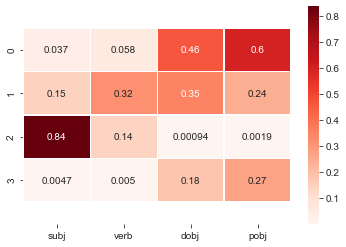

In [7]:

def show_df_hm2(df):
    snsplt = sns.heatmap(df, cmap ='Reds', linewidths = 0.20, annot = True)
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    return snsplt.get_figure()
att_df = pd.DataFrame(enc_att)
print(att_df)
sns_plot = show_df_hm2(att_df)
sns_plot.savefig("enc_att.eps", dpi=100, format='eps')

In [11]:

# for i, batch in enumerate(data.val_iter):
#     text_sents = [' '.join([model.index[model.generated_v].itos[w] 
#                             for w in s]).replace(' <pad>', '').replace(' <eos>', '')
#                   for s in batch.text[:, 1:]]
#     # Getting relations' positions
#     rel_idx = shallow_dependencies(text_sents)
#     for r, t in zip(rel_idx, text_sents):
#         # if r['idx']['verb'][0] > 10:
#         print(r, t)
#     if i>10: break
lv_scores = []
for lv in range(sum(h_params.n_latents)):
    found = {'subj':[], 'verb':[], 'dobj':[], 'pobj':[]}
    for att, rel_pos in zip(att_maxes, rel_idx):
        for k in found.keys():
            if len(rel_pos[k]):
                found[k].append(att[lv] in rel_pos[k])
    lv_scores.append(found)

baseline = []
for k in ['subj', 'verb', 'dobj', 'pobj']:
    all_pos = []
    for pos in rel_idx:
        all_pos.extend(pos[k])
    baseline.append(np.median(all_pos))
print(baseline)

baseline_scores = []
for lv in range(4):
    found = {'subj':[], 'verb':[], 'dobj':[], 'pobj':[]}
    for rel_pos in rel_idx:
        for k in found.keys():
            if len(rel_pos[k]):
                found[k].append(baseline[lv] in rel_pos[k])
    baseline_scores.append(found)
            

# found = {'subj':[], 'verb':[], 'dobj':[], 'pobj':[]}
# for att, rel_pos in zip(att_maxes, rel_idx):
#     for k in found.keys():
#         if len(rel_pos[k]):
#             found[k].append(att[lv][layer] in rel_pos[k])


[1.0, 2.0, 5.0, 7.0]


In [14]:
print("========our Model ========")
Enc_att_scores = {'subj':[], 'verb':[], 'dobj':[], 'pobj':[]}
for lv in range(sum(h_params.n_latents)):
    for layer in range(1):#h_params.encoder_l):
        print("Scores for lv {}, layer {}:".format(lv, layer))
        print({k:np.mean(v)for k, v in lv_scores[lv].items()})
        for k, v in lv_scores[lv].items():
            Enc_att_scores[k].append(np.mean(v))
print("==== Final Scores =======")
enc_max_score = {}
enc_disent_score = {}
enc_disent_vars = {}
for k, v in Enc_att_scores.items():
    sort_idx = np.argsort(v) 
    enc_disent_vars[k] = sort_idx[-1]
    enc_disent_score[k] = v[sort_idx[-1]] - v[sort_idx[-2]]
    enc_max_score[k] = v[sort_idx[-1]]
print(enc_max_score)
print(enc_disent_score)
print(enc_disent_vars)
print("========our baseline ========")

baseline_enc_att_scores = {'subj':[], 'verb':[], 'dobj':[], 'pobj':[]}
for lv in range(len(baseline_scores)):
    for layer in range(1):#h_params.encoder_l):
        print("Scores for lv {}, layer {}:".format(lv, layer))
        print({k:np.mean(v)for k, v in baseline_scores[lv].items()})
        for k, v in baseline_scores[lv].items():
            baseline_enc_att_scores[k].append(np.mean(v))
print("==== Final Scores =======")
enc_max_score = {}
enc_disent_score = {}
enc_disent_vars = {}
for k, v in baseline_enc_att_scores.items():
    sort_idx = np.argsort(v) 
    enc_disent_vars[k] = sort_idx[-1]
    enc_disent_score[k] = v[sort_idx[-1]] - v[sort_idx[-2]]
    enc_max_score[k] = v[sort_idx[-1]]
print(enc_max_score)
print(enc_disent_score, sum(enc_disent_score.values()))
print(enc_disent_vars)

========our Model ========
Scores for lv 0, layer 0:
{'subj': 0.38920863309352516, 'verb': 0.27425, 'dobj': 0.10831426392067124, 'pobj': 0.061317183951551855}
Scores for lv 1, layer 0:
{'subj': 0.11726618705035971, 'verb': 0.12575, 'dobj': 0.38367658276125094, 'pobj': 0.23164269492808479}
Scores for lv 2, layer 0:
{'subj': 0.0, 'verb': 0.0, 'dobj': 0.006864988558352402, 'pobj': 0.008327024981074944}
Scores for lv 3, layer 0:
{'subj': 0.05, 'verb': 0.0335, 'dobj': 0.3531655225019069, 'pobj': 0.36260408781226344}
Scores for lv 4, layer 0:
{'subj': 0.002158273381294964, 'verb': 0.00375, 'dobj': 0.10907704042715484, 'pobj': 0.16654049962149886}
Scores for lv 5, layer 0:
{'subj': 0.02194244604316547, 'verb': 0.03, 'dobj': 0.2387490465293669, 'pobj': 0.33459500378501134}
Scores for lv 6, layer 0:
{'subj': 0.007553956834532374, 'verb': 0.0145, 'dobj': 0.18916857360793288, 'pobj': 0.24072672218016655}
Scores for lv 7, layer 0:
{'subj': 0.7607913669064749, 'verb': 0.09475, 'dobj': 0.00457665903

In [1]:
import spacy
nlp = spacy.load("en_core_web_sm")


In [18]:
ex_sents = ["i 'll never be going back", "great food, great service",
            "decoration is outdated .",
            "the guy in front of us was ordering in spanish .",
            "worst service ever .", "the worst experience i have ever had at an enterprise location .",
            'waitresses are slow', "this place is awful !"]
import itertools
def get_children(tok, depth):
    if depth == 0:
        return list(tok.children)
    else:
        return list(tok.children) + \
               list(itertools.chain.from_iterable([get_children(c, depth-1) for c in tok.children]))

def truncated_template(sents, depth):
    docs = nlp.pipe(sents)
    templates = []
    for doc in docs:
        children = None
        for i, tok in enumerate(doc):
            if tok.dep_ =='ROOT':
                children = [tok]+get_children(tok, depth)
        if children is not None:
            sort_dict_lex = {c.i:c.text for c in children}
            sort_dict_syn = {c.i:c.dep_ for c in children}
            templates.append({'lex': ' '.join([sort_dict_lex[i] for i in sorted(sort_dict_lex.keys())]),
                              'syn': ' '.join([sort_dict_syn[i] for i in sorted(sort_dict_syn.keys())])})
        else: 
            raise NotImplementedError("This sentence has no ROOT: ".format(' '.join([t.text for t in doc])))

    
docs = nlp.pipe(ex_sents)
for doc in docs:
    print(doc.text)
    print(truncated_template(doc, 0))


i 'll never be going back
("i 'll never be going back", 'nsubj aux neg aux ROOT advmod')
great food, great service
('great food , service', 'amod ROOT punct appos')
decoration is outdated .
('decoration is outdated .', 'nsubjpass auxpass ROOT punct')
the guy in front of us was ordering in spanish .
('guy was ordering in .', 'nsubj aux ROOT prep punct')
worst service ever .
('worst service ever .', 'amod ROOT advmod punct')
the worst experience i have ever had at an enterprise location .
('the worst experience had .', 'det amod ROOT relcl punct')
waitresses are slow
('waitresses are slow', 'nsubj ROOT acomp')
this place is awful !
('place is awful !', 'nsubj ROOT acomp punct')


In [5]:
import pandas as pd
from tqdm import tqdm
      
import spacy
from disentanglement_transformer.models import shallow_dependencies, truncated_template
nlp = spacy.load("en_core_web_sm")

ex_sents = ['i was originally told it would take _num_ mins .',
            'slow , over priced , i \'ll go elsewhere next time .',
            'we will not be back',
            'terrible .',
            'at this point they were open and would be for another hour .',
            'people are outside playing baseball .',
            'two dogs pull on opposite ends of a rope .',
            'a lady lays at a beach .',
            'the construction workers are using a pick axes to poke each other .',
            'people are running through the streets while people watch .',
            'someone prepares food into bowls ']
orig = ['Yelp']*5+['SNLI']*5
print([(tok.text, tok.dep_) for tok in nlp(
            'the construction workers are using a pick axes to poke each other .')])


roles, temptypes = ['subj', 'verb', 'dobj', 'pobj'], ['syn', 'lex']
deps = shallow_dependencies(ex_sents)
temps = truncated_template(ex_sents)
print(deps)
for i in range(len(ex_sents)):
    print(orig[i], '& ',ex_sents[i], '& ', '& '.join([deps[i]['text'][k] for k in roles]), '& ',
          '& '.join([temps[i][k] for k in temptypes]), '\\\\ \hline')

[('the', 'det'), ('construction', 'compound'), ('workers', 'nsubj'), ('are', 'aux'), ('using', 'ROOT'), ('a', 'det'), ('pick', 'amod'), ('axes', 'dobj'), ('to', 'aux'), ('poke', 'xcomp'), ('each', 'det'), ('other', 'dobj'), ('.', 'punct')]
[{'text': {'subj': 'it', 'verb': 'told', 'dobj': '_ num _ mins', 'pobj': ''}, 'idx': {'subj': [4], 'verb': [3], 'dobj': [7, 8, 9, 10], 'pobj': []}}, {'text': {'subj': 'i', 'verb': 'go', 'dobj': '', 'pobj': ''}, 'idx': {'subj': [5], 'verb': [7], 'dobj': [], 'pobj': []}}, {'text': {'subj': 'we', 'verb': '', 'dobj': '', 'pobj': ''}, 'idx': {'subj': [0], 'verb': [], 'dobj': [], 'pobj': []}}, {'text': {'subj': '', 'verb': '', 'dobj': '', 'pobj': ''}, 'idx': {'subj': [], 'verb': [], 'dobj': [], 'pobj': []}}, {'text': {'subj': 'they', 'verb': '', 'dobj': '', 'pobj': 'this point'}, 'idx': {'subj': [3], 'verb': [], 'dobj': [], 'pobj': [1, 2]}}, {'text': {'subj': 'people', 'verb': '', 'dobj': 'baseball', 'pobj': ''}, 'idx': {'subj': [0], 'verb': [], 'dobj': [4

IndexError: list index out of range

In [26]:
text, samples, params = model.get_sentences(5, gen_len=16, sample_w=False, vary_z=True, complete=None, contains=None, max_tries=100)

print(text)


[' no server , he was very friendly and helpful ', ' the staff is friendly and helpful and friendly ', ' the place is way more than the food is good ', ' amazing service , what a good time ', " i 've been here twice and we 're quite happy with my experience "]


In [27]:
var_ids = [2]
alt_text, alt_params = model._get_alternative_sentences(samples, None, var_ids, 2, 16, complete=None)
for i in range(len(text)):
    print(text[i], ':', alt_text[i::len(text)])


 no server , he was very friendly and helpful  : [' no server , no flavor ', ' no server , no flavor ']
 the staff is friendly and helpful and friendly  : [" i would n't recommend this for a nice place ", ' wrong ']
 the place is way more than the food is good  : [' the place is way more than the lobby and they are great ', ' the place is way more well and my dogs ']
 amazing service , what a good time  : [' amazing service , what a great place to eat ', ' service is always what they do , everything ']
 i 've been here twice and we 're quite happy with my experience  : [' they are very friendly and helpful ', ' the food was delicious ']


In [36]:
var_ids = [2]
alt_text, alt_params = model._get_alternative_sentences(samples, None, var_ids, 2, 16, complete=None)
for i in range(len(text)):
    print(text[i], ':', alt_text[i::len(text)])

 no server , he was very friendly and helpful  : [' no server , he had to die for our slice of ed ', ' no server , he gave me , but our slice of sort of soup ']
 the staff is friendly and helpful and friendly  : [' wrong ', " i 've been here twice for dinner "]
 the place is way more than the food is good  : [' the place is way more than the food is good ', ' the place is way more than the food is good ']
 amazing service , what a good time  : [' amazing service , what a great place to eat ', " i 've always enjoyed this location because this place was really positive "]
 i 've been here twice and we 're quite happy with my experience  : [' the staff is friendly and the food is quite easy as well ', ' great food ']


In [29]:
var_ids = [3, 4, 5, 6, 7]
alt_text, alt_params = model._get_alternative_sentences(samples, None, var_ids, 2, 16, complete=None)
for i in range(len(text)):
    print(text[i], ':', alt_text[i::len(text)])

 no server , he was very friendly and helpful  : [' great service and great food ', ' great service ']
 the staff is friendly and helpful and friendly  : [' our food was very good and loved it and it disappeared ', ' the staff is friendly and helpful and so hard to pay her cafe ']
 the place is way more than the food is good  : [' the food was delicious and the service was great ', ' the food was delicious and the service was great ']
 amazing service , what a good time  : [' amazing people ', ' the food is always good , service is great ']
 i 've been here twice and we 're quite happy with my experience  : [' the food is always fresh and delicious ', ' i will definitely be back again ']


In [37]:
def decode_to_text(x_hat_params, vocab_size, vocab_index):
    # It is assumed that this function is used at test time for display purposes
    # Getting the argmax from the one hot if it's not done
    while x_hat_params.shape[-1] == vocab_size and x_hat_params.ndim > 3:
        x_hat_params = x_hat_params.mean(0)
    while x_hat_params.ndim > 2 and x_hat_params.shape[-1] != self.h_params.vocab_size:
        x_hat_params = x_hat_params[0]
    if x_hat_params.shape[-1] == vocab_size:
        x_hat_params = torch.argmax(x_hat_params, dim=-1)
    assert x_hat_params.ndim == 2, "Mis-shaped generated sequence: {}".format(x_hat_params.shape)
    
    samples = [' '.join([vocab_index.itos[w]
                         for w in sen]).split('<eos>')[0].split(' !')[0].split(' .')[0].replace('<go>', '').replace('</go>', '')
               .replace('<pad>', '_').replace('_unk', '<?>')
               for sen in x_hat_params]

    return samples


def swap_latents(mdl, prev_latent_vals, var_z_ids, gen_len, complete=None, no_unk=True):
            n_orig_sentences = prev_latent_vals['z1'].shape[0]
            n_samples = n_orig_sentences
            go_symbol = torch.ones([n_samples * n_orig_sentences]).long() * \
                        mdl.index[mdl.generated_v].stoi['<go>']
            go_symbol = go_symbol.to(mdl.h_params.device).unsqueeze(-1)
            x_prev = go_symbol
            if complete is not None:
                for token in complete.split(' '):
                    x_prev = torch.cat([x_prev, torch.ones([n_samples * n_orig_sentences, 1]).long().to(mdl.h_params.device) * \
                        mdl.index[mdl.generated_v].stoi[token]], dim=1)
                gen_len = gen_len - len(complete.split(' '))
            temp = 1.
            orig_z = prev_latent_vals['z1'].unsqueeze(1).repeat(1, n_samples, 1)
            z_sample = orig_z.reshape(n_samples*n_orig_sentences, -1)
            orig_z = orig_z.transpose(0, 1).reshape(n_samples*n_orig_sentences, -1)

            for id in var_z_ids:
                z_number = sum([id> sum(h_params.n_latents[:i+1]) for i in range(len(h_params.n_latents))])
                z_index = id - sum(h_params.n_latents[:z_number])
                start, end = int(h_params.z_size/max(h_params.n_latents)*z_index),\
                             int(h_params.z_size/max(h_params.n_latents)*(z_index+1))
                source, destination = [z_sample][z_number], [orig_z][z_number]
                destination[:, start:end] = source[:, start:end]
            
            z_input = {'z1': orig_z.unsqueeze(1)}
            
            # Normal Autoregressive generation
            for i in range(gen_len):
                mdl.gen_bn({'x_prev': x_prev, **{k: v.expand(v.shape[0], i+1, v.shape[-1])
                                                  for k, v in z_input.items()}})
                samples_i = mdl.generated_v.post_params['logits']
                if no_unk:
                    annul_vector = 1-F.one_hot(torch.tensor([data.vocab.stoi['<unk>']]).to(DEVICE), h_params.vocab_size)
                    samples_i *= annul_vector
                
                x_prev = torch.cat([x_prev, torch.argmax(samples_i,     dim=-1)[..., -1].unsqueeze(-1)],
                                   dim=-1)
            
            text = decode_to_text(x_prev, mdl.h_params.vocab_size, mdl.index[mdl.generated_v])
            return text, {'z1': orig_z}
sw_zs = [2]
sw_text, sw_samples = swap_latents(model, samples, sw_zs, 16, complete=None, no_unk=True)
print(text)
for i in range(len(text)):
    for j in range(len(text)):
        print("orig: \"", text[i], "|z_orig: ", text[j], "|result: ", sw_text[len(text)*i+j])
        


[' no server , he was very friendly and helpful ', ' the staff is friendly and helpful and friendly ', ' the place is way more than the food is good ', ' amazing service , what a good time ', " i 've been here twice and we 're quite happy with my experience "]
orig: "  no server , he was very friendly and helpful  |z_orig:   no server , he was very friendly and helpful  |result:   no server , he was very friendly and helpful
orig: "  no server , he was very friendly and helpful  |z_orig:   the staff is friendly and helpful and friendly  |result:   our waitress was very nice and attentive
orig: "  no server , he was very friendly and helpful  |z_orig:   the place is way more than the food is good  |result:   the place is way more than the food is good
orig: "  no server , he was very friendly and helpful  |z_orig:   amazing service , what a good time  |result:   amazing service , what a great place to eat
orig: "  no server , he was very friendly and helpful  |z_orig:   i 've been here 